In [2]:
import pandas as pd

df_ratings = pd.read_csv('movies_ratings.csv')
df_titles = pd.read_csv('movies_titles.csv')
df_users = pd.read_csv('movies_users.csv')

# **Basic Data Understanding (Exploration)**

In [3]:
# First few rows of the ratings dataframe
head_ratings = df_ratings.head()
print("Head of df_ratings:\n", head_ratings)

# Descriptive statistics of the ratings dataframe
desc_ratings = df_ratings.describe()
print("\nDescriptive statistics of df_ratings:\n", desc_ratings)

# Count of each rating value
rating_counts = df_ratings['rating'].value_counts()
print("\nRating value counts:\n", rating_counts)

# Number of unique users and shows
unique_users = df_ratings['user_id'].nunique()
unique_shows = df_ratings['show_id'].nunique()
print("\nNumber of unique users:", unique_users)
print("Number of unique shows:", unique_shows)


Head of df_ratings:
    user_id show_id  rating
0        1   s8381       4
1        1   s3466       5
2        1   s3181       4
3        1    s294       3
4        1   s7739       5

Descriptive statistics of df_ratings:
            user_id       rating
count  2147.000000  2147.000000
mean    100.693526     3.982767
std      57.759328     0.808956
min       1.000000     3.000000
25%      51.000000     3.000000
50%     101.000000     4.000000
75%     151.000000     5.000000
max     200.000000     5.000000

Rating value counts:
 rating
4    742
3    721
5    684
Name: count, dtype: int64

Number of unique users: 200
Number of unique shows: 1809


There are **2,147 total ratings** across all users and shows
ratings **range from 3 to 5**, which is a narrow range

That could be by design allowing rating 3–5, or it might suggest bias in how users rate, user not rating what they don't like.

The mean rating is about 3.98, and the median is 4, so people generally rate shows quite positively.

The user IDs range from 1 to 200, which matches your unique users count.

Ratings are evenly distributed among 3, 4, and 5 — but again, all ratings are high.

This could affect collaborative filtering: since there's little negative feedback, the model might struggle to distinguish "good" from "excellent" shows.

**Summary**:

- Sparse, **positive-biased** rating data

- A good amount of users (200) and a large catalog of shows (1809)

- A need to fill in missing values or predict unseen ratings — exactly what collaborative filtering is designed to solve.

In [4]:
df_users.describe(include='all')
df_users['gender'].value_counts()

gender
Male      98
Female    98
Other      4
Name: count, dtype: int64

# **df_users understanding**

In [5]:
user_description = df_users.describe(include='all')
gender_counts = df_users['gender'].value_counts()

print("\nDescriptive statistics of df_users:\n", user_description)
print("\nGender value counts:\n", gender_counts)


Descriptive statistics of df_users:
            user_id            name         phone               email  \
count   200.000000             200           200                 200   
unique         NaN             199           200                 200   
top            NaN  Mark Hernandez  890.309.2971  esmith@hotmail.com   
freq           NaN               2             1                   1   
mean    100.500000             NaN           NaN                 NaN   
std      57.879185             NaN           NaN                 NaN   
min       1.000000             NaN           NaN                 NaN   
25%      50.750000             NaN           NaN                 NaN   
50%     100.500000             NaN           NaN                 NaN   
75%     150.250000             NaN           NaN                 NaN   
max     200.000000             NaN           NaN                 NaN   

               age gender     Netflix  Amazon Prime     Disney+  Paramount+  \
count   200.000000

user_id: Goes from 1 to 200. As expected, 200 users.



Your users are **diverse** in age, location, and streaming subscriptions.

Subscription columns could help do content-based hybrid filtering (e.g., only recommend shows from platforms users have access to).

# **df_titles understanding**

<Axes: xlabel='release_year'>

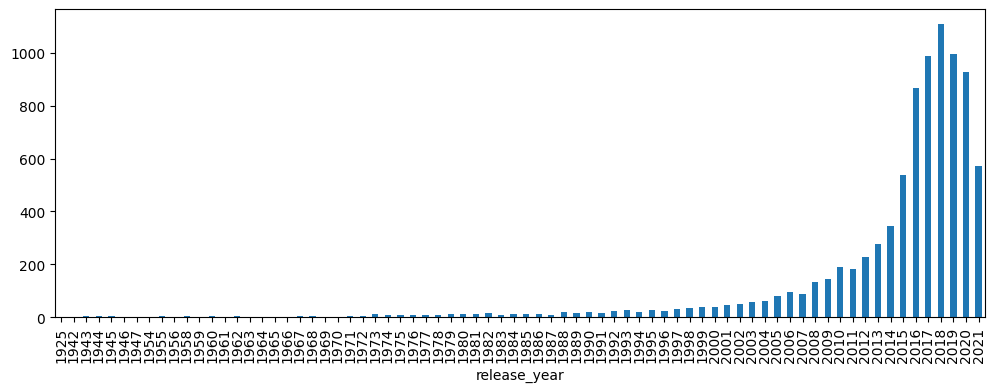

In [6]:
df_titles['release_year'].value_counts().sort_index().plot(kind='bar', figsize=(12, 4))

The bar plot of release years shows a **significant increase in the number of titles released in more recent years**. This **could suggest a trend where newer content is more abundant than older content**, reflecting the increasing volume of productions in recent times. This trend might also highlight the popularity and demand for newer content, which could be important for understanding the relevance and availability of shows or movies in the current market.

# **Missing Data**

In [7]:
def check_missing_values(dfs, df_names):
    for df, name in zip(dfs, df_names):
        print(f"--- Checking DataFrame: {name} ---")
        print(f"Shape: {df.shape}")

        missing = df.isnull().sum()
        missing = missing[missing > 0]  # Filter only columns with missing values

        if missing.empty:
            print("✅ No missing values in this DataFrame.\n")
        else:
            print("⚠️ Columns with missing values:")
            for col, num_missing in missing.items():
                percent = (num_missing / len(df)) * 100
                print(f" - {col}: {num_missing} missing ({percent:.2f}%)")
            print()

# Example usage with your dataframes
check_missing_values(
    dfs=[df_ratings, df_titles, df_users],
    df_names=["df_ratings", "df_titles", "df_users"]
)


--- Checking DataFrame: df_ratings ---
Shape: (2147, 3)
✅ No missing values in this DataFrame.

--- Checking DataFrame: df_titles ---
Shape: (8508, 42)
⚠️ Columns with missing values:
 - director: 2114 missing (24.85%)
 - cast: 119 missing (1.40%)
 - country: 814 missing (9.57%)
 - rating: 4 missing (0.05%)
 - duration: 1 missing (0.01%)

--- Checking DataFrame: df_users ---
Shape: (200, 17)
✅ No missing values in this DataFrame.



<Axes: xlabel='rating', ylabel='Count'>

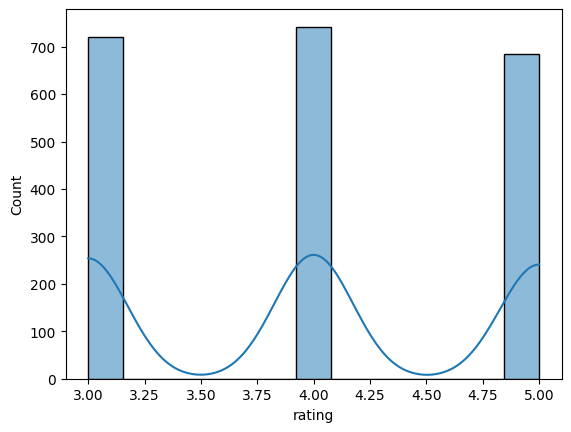

In [8]:
import seaborn as sns
sns.histplot(df_ratings['rating'], kde=True)

# **Sparsity**

A matrix is considered highly sparse when most of the entries are missing or have no value (i.e., are **zeros** or **NaNs**).

In [9]:
user_item_matrix = df_ratings.pivot(index='user_id', columns='show_id', values='rating')
sparsity = 1 - (user_item_matrix.count().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]))
print(f"Sparsity of the matrix: {sparsity:.4f}")

Sparsity of the matrix: 0.9941


Sparsity of 0.9941 means the matrix is **extremely sparse**, with only about 0.59% of the values filled, and **99.41% of the values are missing**.

**Zero duplicate**

In [10]:
print(f"Duplicate ratings: {df_ratings.duplicated(subset=['user_id', 'show_id']).sum()}")

Duplicate ratings: 0


In [11]:
print(df_ratings['show_id'].value_counts())

show_id
s6508    4
s3282    4
s2179    4
s7748    4
s8804    4
        ..
s267     1
s3879    1
s2992    1
s806     1
s3181    1
Name: count, Length: 1809, dtype: int64


In [12]:
print(df_ratings['user_id'].value_counts())

user_id
1      11
2      11
3      11
4      11
5      11
       ..
34      9
132     9
109     9
138     9
182     9
Name: count, Length: 200, dtype: int64


**rating_percentages shows the proportion of movies that received 1, 2, 3, and 4 ratings.**

In [13]:
# Count the number of ratings for each movie
value_counts = df_ratings['show_id'].value_counts()

# Calculate the percentage of movies rated only once, twice, etc.
rating_percentages = value_counts.value_counts(normalize=True) * 100

# Print the percentages
print("\nPercentage of movies receiving a certain number of ratings:")
rating_percentages


Percentage of movies receiving a certain number of ratings:


count
1    83.692648
2    14.262023
3     1.713654
4     0.331675
Name: proportion, dtype: float64

**83.69%** of the movies have been rated only once.

**14.26%** of the movies have been **rated twice**.

**1.71%** of the movies have been rated **three time**s

**0.33%** of the movies have been rated **four times.**

# **Interpretation**

**Skewed Rating Distribution**: The vast majority of movies (83.69%) have only received a single rating. This suggests that most movies are either not very popular or are not being rated by a broad audience, resulting in a large number of shows with minimal feedback.

**Few Movies Get Multiple Ratings**: ***A smaller percentage of movies (14.26%)*** are rated more than once, and the number rapidly drops as the number of ratings increases. This indicates a strong imbalance in how movies are rated, where a small fraction of movies are rated multiple times, while most movies barely receive any engagement.



# **Implications for Collaborative Filtering**

The high percentage of movies rated only once creates a challenge for collaborative filtering. **If only a single rating exists for most movies, it becomes difficult to generate accurate recommendations for those movies.** Collaborative filtering relies on user interaction data, and with so many movies rated only once, the system will have limited information to work with for personalized recommendations.

**Potential for Improving Engagement**: Since most movies receive very few ratings, it might be useful to implement strategies for increasing engagement with less-rated content. This could involve better recommendations, highlighting hidden gems, or increasing visibility for shows that are less likely to be rated.

# **BAR CHART**

**bar charts of the most and least popular movies as well as the count of ratings for those records.**

         ratings_count  ratings_mean                               title
show_id                                                                 
s1004                1           5.0                                Zero
s1005                1           3.0                  Izzy's Koala World
s1006                1           5.0  Keymon and Nani in Space Adventure
s1007                1           4.0            Motu Patlu Dino Invasion
s1018                1           5.0         Dhobi Ghat (Mumbai Diaries)
         ratings_count  ratings_mean                               title
show_id                                                                 
s1078                1           5.0        Shiva: Journey to Plunotaria
s994                 1           5.0                     Shadow and Bone
s1004                1           5.0                                Zero
s988                 1           5.0                          Legal Hash
s1006                1           5.0  Keymon and Na

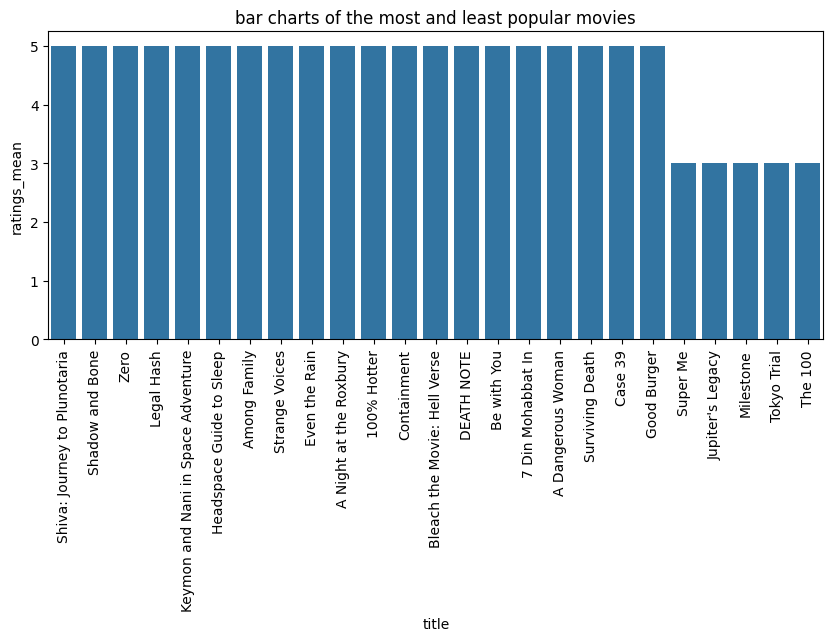

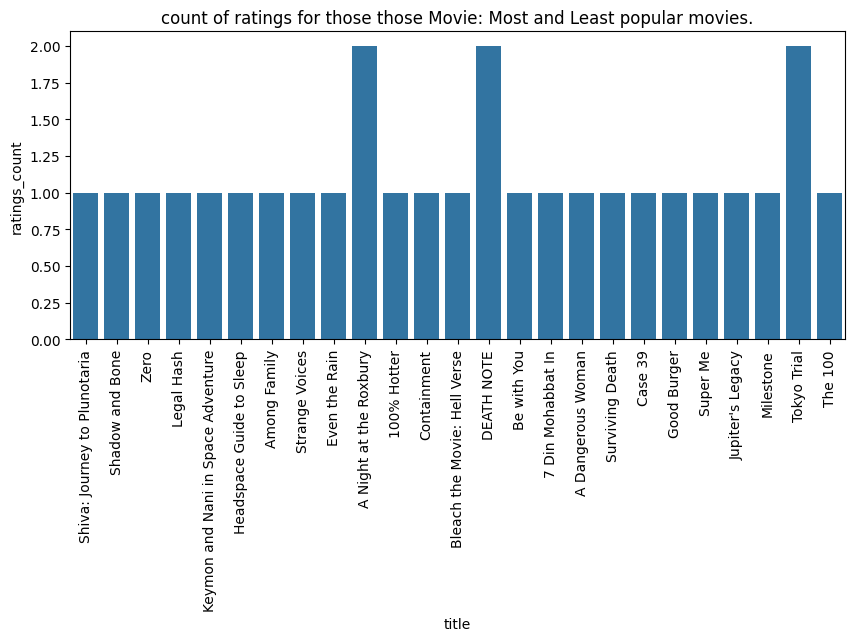

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the rows into individual titles and calculate the mean rating for each row
movie_stats = df_ratings.groupby(by=['show_id'])[['rating']].agg(['count', 'mean'])
movie_stats.columns = ['ratings_count', 'ratings_mean']  # Rename the columns to simplify the index

# Join with df_titles to get the titles, ensuring show_id matches exactly
movie_stats = movie_stats.join(df_titles.set_index('show_id')['title'], on='show_id')

# Check if the join worked correctly
print(movie_stats.head())  # Verify the data after join

# Sort the ratings by mean
movie_stats = movie_stats.sort_values(by=['ratings_mean'], ascending=False)

# Create a smaller dataset of the top n and bottom n rated movies
df_reduced = pd.concat([movie_stats.head(20), movie_stats.tail(5)])

# Check if df_reduced has valid data
print(f"{df_reduced.head()}\n\n")  # Verify the content of df_reduced

# Plot the average rating for each movie
plt.figure(figsize=(10,4))  # Set the size of the figure
sns.barplot(data=df_reduced, x='title', y='ratings_mean')
plt.xticks(rotation=90)
plt.title('bar charts of the most and least popular movies')  # Add title
plt.show()

# Plot the ratings count for each movie
plt.figure(figsize=(10,4))  # Set the size of the figure
sns.barplot(data=df_reduced, x='title', y='ratings_count')
plt.xticks(rotation=90)
plt.title('count of ratings for those those Movie: Most and Least popular movies.')  # Add title
plt.show()

# **Model Fitting: Calculating Similarity**

This matrix is the foundation for collaborative filtering. You can:
Compare users by their rating patterns.
Find similar movies.
Predict what a user might rate a movie they haven't seen yet.

In [15]:
def create_matrix(df, user, item, rating):
  import numpy as np
  from scipy.sparse import csr_matrix

  U = df[user].nunique()  # Number of users for the matrix
  I = df[item].nunique()  # Number of items for the matrix

  # Map user and movie IDs to matrix indices
  user_mapper = dict(zip(np.unique(df[user]), list(range(U))))
  item_mapper = dict(zip(np.unique(df[item]), list(range(I))))

  # Map matrix indices back to IDs
  user_inv_mapper = dict(zip(list(range(U)), np.unique(df[user])))
  item_inv_mapper = dict(zip(list(range(I)), np.unique(df[item])))

  # Create a list of index values for the csr_matrix for users and movies
  user_index = [user_mapper[i] for i in df[user]]
  item_index = [item_mapper[i] for i in df[item]]

  # Build the final matrix which will look like: (movieId, userId) rating
  X = csr_matrix((df[rating], (item_index, user_index)), shape=(I, U))

  return X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper

In [16]:
X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper = create_matrix(df_ratings, 'user_id', 'show_id', 'rating')

In [17]:
# This prints the big table (actually a matrix!) where:
# - each row is a movie
# - each column is a user
# - the number inside is the rating that user gave to the movie
# It's a sparse matrix, so it only shows where ratings exist
print(f"{X}\n")  # (movieId, userId)   rating

# This shows a dictionary that turns a real user ID into a number (like giving each user a seat number)
# For example, user "abc123" might be user number 0 in the matrix
print(f"{user_mapper}\n")

# This does the opposite: it turns a user number (like 0, 1, 2...) back into their real user ID
# It's helpful when we want to know *who* user 0 really is
print(f"{user_inv_mapper}\n")

# Same idea for movies! This turns a movie's real ID into a number so we can put it into our matrix
print(f"{item_mapper}\n")

# And this turns the number back into the movie's real ID (so we can show which movie we're talking about)
print(item_inv_mapper)


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2147 stored elements and shape (1809, 200)>
  Coords	Values
  (0, 179)	5
  (1, 103)	3
  (2, 67)	5
  (3, 99)	4
  (4, 144)	5
  (5, 158)	3
  (6, 50)	3
  (6, 124)	3
  (7, 171)	5
  (8, 19)	5
  (8, 78)	5
  (8, 138)	4
  (9, 4)	5
  (9, 160)	4
  (10, 176)	5
  (11, 121)	3
  (12, 112)	3
  (13, 136)	4
  (14, 78)	5
  (15, 132)	3
  (16, 142)	4
  (16, 193)	4
  (17, 52)	4
  (18, 53)	3
  (18, 54)	4
  :	:
  (1785, 28)	5
  (1786, 180)	3
  (1787, 1)	3
  (1788, 151)	3
  (1789, 47)	4
  (1789, 165)	3
  (1790, 24)	4
  (1791, 148)	3
  (1792, 35)	4
  (1793, 30)	4
  (1794, 166)	4
  (1795, 142)	4
  (1796, 110)	4
  (1797, 69)	3
  (1798, 175)	3
  (1799, 65)	4
  (1800, 180)	3
  (1801, 170)	5
  (1802, 155)	4
  (1803, 125)	5
  (1804, 184)	5
  (1805, 40)	5
  (1806, 33)	5
  (1807, 33)	3
  (1808, 120)	5

{np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3, np.int64(5): 4, np.int64(6): 5, np.int64(7): 6, np.int64(8): 7, np.int64(9): 8, np.int64(10): 9

**Let's see what rating did user 2 give to movie 67?**

In [18]:
value = X[2, 67]
print(value)

5


**find the CORRESPONDING userId and movieId in your ORIGINAL DataFrame, you can use the inverse mapping you created earlier:**

In [19]:
print(f"The rating given by user {user_inv_mapper[2]} to movie {item_inv_mapper[67]} is {value}.")


The rating given by user 3 to movie s1318 is 5.


In [20]:
# Get the userId and movieId for the coordinates (0, 30)
Original_show_id = item_inv_mapper[2]  # Get the original movieId from the index 0
Original_user_id = user_inv_mapper[67]  # Get the original userId from the index 30

# Now, you can print the movieId, userId, and rating
print(f'Origianl show_id: {Original_show_id}, Origianl UserId: {Original_user_id}, Rating: {X[2, 67]}')

Origianl show_id: s1006, Origianl UserId: 68, Rating: 5


In [21]:
sparsity = round(1.0 - len(df_ratings) / float(len(user_mapper) * len(item_mapper)), 3)
print('The sparsity level of this matrix is {}%'.format(sparsity * 100))

# Calculate the percentage of movies rated by each user
rating_percentage = round(100 - sparsity * 100, 2)
print(f'\nThis means that each user has rated {rating_percentage}% of the movies in this database.')

# Calculate the number of movies rated by each user
num_movies_rated_by_user = round(rating_percentage / 100 * df_ratings.show_id.nunique(), 0)
print(f"\nEach user has rated approximately {num_movies_rated_by_user} movies in the database")

The sparsity level of this matrix is 99.4%

This means that each user has rated 0.6% of the movies in this database.

Each user has rated approximately 11.0 movies in the database


Our Sparsity of 99.4% means the matrix is **extremely sparse**, with only about 0.6% of the values are filled, and **99.41% of the values are missing**.

# **Model Fitting: Calculate Similarity**

Because we have discrete data with few values (e.g. 1, 2, 3), then a manhattan or cityblock distance may be better

- This function finds movies that are similar to one specific movie.
- It looks at how people rated the movie and compares it to how they rated other movies.
- Then it gives you a list of the most similar movies and how close they are.

In [22]:
def recommend(itemId, X, item_mapper, item_inv_mapper, k, metric='manhattan', messages=True):
  from sklearn.neighbors import NearestNeighbors

  rec_ids = []                # Make a list for the recommended item IDs we'll get later
  item = item_mapper[itemId]  # Get the index of the movie ID passed into the function
  item_vector = X[item]       # Get the vector of user ratings for the movie ID passed into the function

  # Fit the clustering algorithm based on the user-item matrix X
  knn = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric).fit(X)

  # Call the trained knn cluster model to return the nearest neighbors of the item_vector passed in
  rec = knn.kneighbors(item_vector.reshape(1,-1), return_distance=True)
  rec_indeces = rec[1][0]     # Parse out the list of indeces of the recommended items
  rec_distances = rec[0][0]   # Parse out the recommendation strength calculated as the distance from the cluster center
  rec_distances = np.delete(rec_distances, 0) # Drop the first number in the list because it is the distance of itemId from itself

  # We need to replace the recommended item indeces with their original item IDs
  for i in range(1, knn.n_neighbors): # n_neighbors is the number of neighbors to return
    rec_ids.append(item_inv_mapper[rec_indeces[i]])

  # It may help to see what this is. The distance list is first and the recommended item indeces are second
  if messages:
    print(f'List of recommended item indeces:\n{rec_indeces}\n')
    print(f'List of recommended item IDs:\n{rec_ids}\n')
    print(f'List of recommended item similarity to selected item:\n{rec_distances}\n')

  # Return two lists: the original item IDs of the recommendations and their similarity scores
  return rec_ids, rec_distances

In [23]:
df_titles.set_index('show_id', inplace=True)


**Movie Recommendation Based on a Selected Title**

In [24]:
import numpy as np
# select the movie for which you want to get recommendations.

show_id = 's4'
# find the 10 movies most similar to the movie with the ID movie_id
rec_ids, rec_distances = recommend(show_id, X, item_mapper, item_inv_mapper, k=10)

print(f"\n\nA user who liked the show: {df_titles.loc[show_id, 'title']},\n you may also enjoy the 10 following shows:\n")
df_titles.loc[rec_ids, 'title']

List of recommended item indeces:
[ 528  715 1158  289  947  142 1257    0 1388 1746   79]

List of recommended item IDs:
['s4', 's5883', 's224', 's4909', 's1659', 's6358', 's1004', 's701', 's8654', 's1373']

List of recommended item similarity to selected item:
[0. 0. 1. 1. 1. 2. 2. 4. 5. 6.]



A user who liked the show: Jailbirds New Orleans,
 you may also enjoy the 10 following shows:



show_id
s4                               Jailbirds New Orleans
s5883                                          Atelier
s224     John of God: The Crimes of a Spiritual Healer
s4909                                   Goodnight DJ 1
s1659                                        Valentino
s6358                                     Bondi Rescue
s1004                                             Zero
s701                                Record of Ragnarok
s8654                                    Ugly Duckling
s1373                                      June & Kopi
Name: title, dtype: object

# **Deployment**

In [25]:
k= 15

df_recommendations = pd.DataFrame(columns=['If you watched'], index=item_mapper)
for i in range(1, k):
  df_recommendations[f'Recommendation {i}'] = None

for row in df_recommendations.itertuples():
  # Get a ranked list of recommendati ons
  rec_ids, rec_distances = recommend(row[0], X, item_mapper, item_inv_mapper, k=k, messages=False)

  # Get the title of the 'watched' movie in this row
  df_recommendations.at[row[0], 'If you watched'] = df_titles.at[row[0], 'title']

  # Get the titles of the recommended movies
  for i, r in enumerate(rec_ids):
    df_recommendations.at[row[0], f'Recommendation {i+1}'] = df_titles.at[r, 'title']

Get recommendations for the last 10 movies

In [26]:
df_recommendations.tail(10)

,If you watched,Recommendation 1,Recommendation 2,Recommendation 3,Recommendation 4,Recommendation 5,Recommendation 6,Recommendation 7,Recommendation 8,Recommendation 9,Recommendation 10,Recommendation 11,Recommendation 12,Recommendation 13,Recommendation 14,Recommendation 15
s962,The Mitchells vs. The Machines,Truckbhar Swapna,The Mitchells vs. The Machines,Run,B: The Beginning,The Old Thieves: The Legend of Artegios,Our Souls at Night,The Idhun Chronicles,Deep Blue Sea,Creep 2,Alexis Viera: A Story of Surviving,June & Kopi,Kilometers and Kilometers,Blown Away,Jab Harry Met Sejal,The Family Court
s966,Yasuke,Yasuke,Super Me,Waar,Gunjan Saxena: The Kargil Girl,Thaandavam,Top 10 Secrets and Mysteries,The Daily Life of the Immortal King,Kill la Kill,Kilometers and Kilometers,Jab Harry Met Sejal,The Family Court,The Mist,Belief: The Possession of Janet Moses,Our Souls at Night,Terrace House: Aloha State
s968,Headspace Guide to Sleep,Flowers,The Comedy Lineup,The Making of Frozen Planet,Love Cheque Charge,The Uncanny Counter,Rotten,The Frozen Dead,Red vs. Blue,Blown Away,The Family Court,The Mist,Belief: The Possession of Janet Moses,Our Souls at Night,Terrace House: Aloha State,Gaga: Five Foot Two
s973,Fatma,Fatma,Intersection,Secret of the Nile,Black Earth Rising,We Are the Wave,Lost & Found Music Studios,All Hail King Julien: Exiled,Revenge,Traitors,Ghosts of Sugar Land,Martin Matte: La vie la mort...eh la la..!,The Influence,The Spooky Tale of Captain Underpants Hack-a-ween,Shine On with Reese,Wait My Youth
s977,Among Family,Running Shaadi,Austin Powers: International Man of Mystery,Among Family,Love You... Love You Not,The World Is Yours,Julie & Julia,Mimi,Zig & Sharko,The I-Land,Rita,Katla,Hotel Beau Séjour,Wait My Youth,Little Singham: Kaal Ki Tabaahi,Ghosts of Sugar Land
s98,Kid Cosmic,Kid Cosmic,The Ranch,Until Dawn,Servant of the People,The Chair,Derek,Mystery Science Theater 3000: The Return,The Kominsky Method,Zig & Sharko,Accidentally in Love,June & Kopi,Kilometers and Kilometers,Blown Away,The Family Court,The Mist
s985,Kara Bela,Ghost Pain,Wave of Cinema: Surat dari Timur,Kara Bela,Something Huge,Master,Bhouri,Paskal,Badha,Pizza,Marseille,June & Kopi,Kilometers and Kilometers,Blown Away,The Family Court,The Mist
s988,Legal Hash,Omar and Salma 3,Legal Hash,Sakaling Maging Tayo,High & Low The Movie 2 / End of Sky,The Third Party,Riphagen - The Untouchable,My Travel Buddy,Whipped,The Family Court,The Mist,Belief: The Possession of Janet Moses,Our Souls at Night,Terrace House: Aloha State,Gaga: Five Foot Two,Law School
s990,My Travel Buddy,Riphagen - The Untouchable,The Third Party,Sakaling Maging Tayo,High & Low The Movie 2 / End of Sky,Seoul Searching,Omar and Salma 3,Legal Hash,Whipped,The Family Court,The Mist,Belief: The Possession of Janet Moses,Our Souls at Night,Terrace House: Aloha State,Gaga: Five Foot Two,Law School
s994,Shadow and Bone,Once Upon A Time In Lingjian Mountain,Ares,The Umbrella Academy,A House of Blocks,The Dragon Prince,Parasyte: The Maxim,Supergirl,Mystery Science Theater 3000: The Return,Star Trek: Enterprise,Two Lovers and a Bear,Under an Arctic Sky,Waar,Waiting,The Underclass,Shiva: The Secret World Of Vedas City


In [27]:
k = 15

# Initialize recommendations DataFrame using show_ids as index
df_ShowRecommendations = pd.DataFrame(columns=['If you watched'], index=item_mapper)

# Initialize recommendations columns for the top k recommendations
for i in range(1, k):
    df_ShowRecommendations[f'Recommendation {i}'] = None

# Generate recommendations for all the show_ids
for row in df_ShowRecommendations.itertuples():
    # Get a ranked list of recommendations (using show_id)
    rec_ids, rec_distances = recommend(row[0], X, item_mapper, item_inv_mapper, k=k, messages=False)

    # Store the show_id of the watched movie (show_id)
    df_ShowRecommendations.at[row[0], 'If you watched'] = row[0]

    # Store the show_ids of the recommended shows
    for i, r in enumerate(rec_ids):
        df_ShowRecommendations.at[row[0], f'Recommendation {i+1}'] = r

# Display the resulting DataFrame with show_ids instead of titles
df_ShowRecommendations.head(10)  # Just for a sample output


,If you watched,Recommendation 1,Recommendation 2,Recommendation 3,Recommendation 4,Recommendation 5,Recommendation 6,Recommendation 7,Recommendation 8,Recommendation 9,Recommendation 10,Recommendation 11,Recommendation 12,Recommendation 13,Recommendation 14,Recommendation 15
s1004,s1004,s6358,s224,s4909,s1659,s4,s5883,s3256,s8654,s701,s1929,s1373,s1377,s5192,s5206,s5219
s1005,s1005,s1005,s5992,s7589,s6839,s3570,s4396,s7434,s5111,s1384,s5192,s5206,s5219,s5256,s5263,s5267
s1006,s1006,s1006,s3910,s5134,s6054,s5116,s2208,s883,s5074,s8646,s4516,s1357,s1373,s1377,s5192,s5206
s1007,s1007,s2933,s1007,s5108,s2812,s6092,s5779,s5341,s5858,s8249,s8079,s5192,s5206,s5219,s5256,s5263
s1018,s1018,s4625,s1018,s478,s5744,s694,s2646,s6111,s6316,s193,s4646,s1384,s5192,s5206,s5219,s5256
s1028,s1028,s6209,s8222,s8385,s1028,s8343,s1776,s2176,s1715,s1844,s5192,s5206,s5219,s5256,s5263,s5267
s1037,s1037,s162,s6635,s4937,s5783,s3892,s7599,s3583,s5451,s8221,s2391,s4986,s8218,s4648,s5497,s3955
s1040,s1040,s6607,s6128,s5267,s7713,s46,s8658,s3380,s8523,s8623,s263,s8650,s1068,s1079,s1085,s1157
s1041,s1041,s4377,s225,s6819,s1078,s7418,s591,s460,s7719,s5754,s1636,s3337,s3138,s4419,s6110,s4605
s1060,s1060,s821,s5471,s8084,s3764,s3888,s7289,s1493,s473,s2175,s2038,s2255,s3582,s5,s4858,s5803


In [33]:
import numpy as np

# Set print options to display the full array
np.set_printoptions(threshold=np.inf)

# Display the full array
print(", ".join(f"'{item}'" for item in df_ShowRecommendations['If you watched'].to_numpy()))


's1004', 's1005', 's1006', 's1007', 's1018', 's1028', 's1037', 's1040', 's1041', 's1060', 's1061', 's1063', 's1068', 's1073', 's1078', 's1079', 's1080', 's1081', 's1083', 's1085', 's1087', 's1096', 's11', 's1102', 's1109', 's1114', 's1115', 's1119', 's1128', 's1134', 's1138', 's1144', 's1146', 's1147', 's1148', 's115', 's1157', 's116', 's1173', 's1174', 's1187', 's119', 's1191', 's1195', 's12', 's120', 's1207', 's1208', 's1211', 's1216', 's1221', 's1226', 's1231', 's124', 's1256', 's1257', 's1261', 's1269', 's127', 's1276', 's1277', 's1288', 's1290', 's1300', 's1303', 's1306', 's131', 's1318', 's1323', 's1325', 's1333', 's1335', 's1336', 's1339', 's1350', 's1357', 's1363', 's1365', 's1366', 's1373', 's1374', 's1377', 's1378', 's1384', 's1402', 's1403', 's1409', 's1416', 's1420', 's1429', 's1430', 's1433', 's1438', 's1448', 's1449', 's1454', 's1455', 's1457', 's146', 's1461', 's1463', 's1465', 's1466', 's1468', 's1474', 's1479', 's1484', 's1488', 's1492', 's1493', 's1515', 's1517', 's15

In [29]:
import sqlite3

db_name = "show_collaborative_filter.db"
conn= sqlite3.connect(db_name)

df_ShowRecommendations.to_sql('collaborative_recommendations', conn, if_exists='replace', index=False)

conn.close()